# Video DMA Test

Transfer a frame of data from one Video DMA to a second Video DMA.

This driver was built from [AXI Video Direct Memory Access V6.2](https://www.xilinx.com/support/documentation/ip_documentation/axi_vdma/v6_2/pg020_axi_vdma.pdf)

## Sending a frame

In order to send a frame through the VDMA the following steps are provided:

1. Instantiate the VDMA core.
    ```python
    vdma_egress = VDMA(name = VDMA_NAME_IN_IP)
    ```
2. Set the size of the image.
    ```python
    vdma_egress.set_image_size(WIDTH, HEIGHT)
    ```
3. Write an image to one of the internal buffers.
    ```python
    image_in = np.zeros((HEIGHT, WIDTH, 3)).astype(np.uint8)
    i = 0
    for y in range(HEIGHT):
        for x in range(WIDTH):
            for p in range(3):
                image_in[y, x, p] = i
                if i < 255:
                    i += 1
                else:
                    i = 0
                    
    egress_frame = vdma_egress.get_frame(<0 - 2>)
    egress_frame.set_bytearray(bytearray(image_in.astype(np.int8).tobytes()))
    ```
4. Start the Egress Engine.
    ```python
    vdma_egress.start_egress_engine(continuous = <True/False>,
                                    parked = <True/False>,
                                    num_frames = <number of frames to send>,
                                    frame_index = <frame to start sending>,
                                    interrupt = <True/False>)
    ```

## Receiving a frame

In order to receive a frame from the VDMA the following steps are provided:

1. Instantiate the VDMA core.
    ```python
    vdma_ingress = VDMA(name = VDMA_NAME_IN_IP)
    ```
2. Set the size of the image.
    ```python
    vdma_ingress.set_image_size(WIDTH, HEIGHT)
    ```
3. Start the ingress engine.
    ```python
    vdma_ingress.start_ingress_engine(   continuous = <True/False>,
                                         parked = <True/False>,
                                         num_frames = <number of frames to receive>,
                                         frame_index = <frame to start saving data to>,
                                         interrupt = <True/False>)
    ```
4. Stop the ingress engine.
    ```python
    vdma_ingress.stop_ingress_engine()
    ```

Frame width, height: 1920, 1080

Running? Egress:Ingress False:False
Enabling One of the Engine
Running? Egress:Ingress False:True

Enabling Both Engines

Both of the engines should be halted after transferring one frame
Running? Egress:Ingress False:False

Disabling both engines
Running? Egress:Ingress False:False


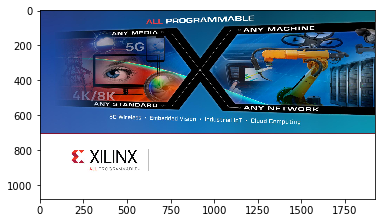

In [1]:
# %matplotlib inline 

from time import sleep
from pynq import Overlay
from pynq.drivers import VDMA

from pynq.drivers import Frame
from pynq.drivers import video
import cv2
from matplotlib import pyplot as plt
from IPython.display import Image
import numpy as np


#Constants
BITFILE_NAME      = "/home/xilinx/jupyter_notebooks/bits/simple_vdma.bit"
EGRESS_VDMA_NAME  = "SEG_axi_vdma_0_Reg"
INGRESS_VDMA_NAME = "SEG_axi_vdma_1_Reg"
IMAGE_FILE        = "/home/xilinx/jupyter_notebooks/examples/data/orig.jpg"

# Set Debug to true to enable debug messages from the VDMA core
DEBUG = False
#DEBUG = True

# Set Verbose to true to dump a lot of messages about
VERBOSE = False
#VERBOSE = True

#These can be set between 0 - 2, the VDMA can also be configured for up to 32 frames in 32-bit memspace and 16 in 64-bit memspace
EGRESS_FRAME_INDEX  = 0
INGRESS_FRAME_INDEX = 0
    
image_in = cv2.imread(IMAGE_FILE)
    
#Flip the color, the image stored in the image
image_in = cv2.cvtColor(image_in, cv2.COLOR_BGR2RGB)
IMAGE_WIDTH = image_in.shape[1]
IMAGE_HEIGHT = image_in.shape[0]


#Download Images
ol = Overlay(BITFILE_NAME)
ol.download()

vdma_egress  = VDMA(name = EGRESS_VDMA_NAME,  debug = DEBUG)
vdma_ingress = VDMA(name = INGRESS_VDMA_NAME, debug = DEBUG)

#Set the size of the image
vdma_egress.set_image_size(IMAGE_WIDTH, IMAGE_HEIGHT)
vdma_ingress.set_image_size(IMAGE_WIDTH, IMAGE_HEIGHT)

#The above functions created the video frames

#Create a Numpy NDArray
frame_out = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3)).astype(np.uint8)
frame_out[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH, :] = image_in[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH, :]


#Populate the frame
frame = vdma_egress.get_frame(EGRESS_FRAME_INDEX)
frame.set_bytearray(bytearray(frame_out.astype(np.int8).tobytes()))

print ("Frame width, height: %d, %d" % (frame.width, frame.height))

print ("")

print ("Running? Egress:Ingress %s:%s" % (vdma_egress.is_egress_enabled(), vdma_ingress.is_ingress_enabled()))


if VERBOSE:
    vdma_egress.dump_egress_registers()
    vdma_ingress.dump_ingress_registers()
    print ("")
print ("Enabling One of the Engine")

#Open Up the Ingress Side
vdma_ingress.start_ingress_engine(  continuous  = False,
                                    num_frames  = 1,
                                    frame_index = INGRESS_FRAME_INDEX,
                                    interrupt   = False)


if VERBOSE:
    vdma_egress.dump_egress_registers()
    vdma_ingress.dump_ingress_registers()

print ("Running? Egress:Ingress %s:%s" % (vdma_egress.is_egress_enabled(), vdma_ingress.is_ingress_enabled()))


print ("")
print ("Enabling Both Engines")

#Quick Start
vdma_egress.start_egress_engine(    continuous  = False,
                                    num_frames  = 1,
                                    frame_index = EGRESS_FRAME_INDEX,
                                    interrupt   = False)


print ("")
print ("Both of the engines should be halted after transferring one frame")

#XXX: I think this sleep isn't needed but the core erroniously reports an engine isn't finished even though it is.
#XXX: This sleep line can be commented out but the egress core may report it is not finished.
sleep(0.1)

if VERBOSE:
    vdma_egress.dump_egress_registers()
    vdma_ingress.dump_ingress_registers()

print ("Running? Egress:Ingress %s:%s" % (vdma_egress.is_egress_enabled(), vdma_ingress.is_ingress_enabled()))

if VERBOSE:
    print ("Egress WIP:  %d" % vdma_egress.get_wip_egress_frame())
    print ("Ingress WIP: %d" % vdma_ingress.get_wip_ingress_frame())

#Check to see if the egress frame point progressed

print ("")
print ("Disabling both engines")

#Disable both
vdma_egress.stop_egress_engine()
vdma_ingress.stop_ingress_engine()

print ("Running? Egress:Ingress %s:%s" % (vdma_egress.is_egress_enabled(), vdma_ingress.is_ingress_enabled()))

if VERBOSE:
    vdma_egress.dump_egress_registers()
    vdma_ingress.dump_ingress_registers()
    print ("Egress Error:  0x%08X" % vdma_egress.get_egress_error())
    print ("Ingress Error: 0x%08X" % vdma_ingress.get_ingress_error())

frame = vdma_ingress.get_frame(INGRESS_FRAME_INDEX)
frame.save_as_jpeg("./image.jpg")


np_frame = np.ndarray(  shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                        dtype=np.uint8,
                        buffer = frame.get_bytearray())

#SHOW IMAGE
plt.imshow(np_frame)
plt.show()

